In [2]:
from kedro.framework.session import KedroSession
from kedro.framework.startup import bootstrap_project
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import matplotlib.pyplot as plt

[02/20/25 12:10:02] INFO     Using                                                                  ]8;id=139746;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/framework/project/__init__.py\__init__.py]8;;\:]8;id=835602;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/framework/project/__init__.py#270\270]8;;\
                             '/opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/                
                             framework/project/rich_logging.yml' as logging configuration.                         

In [69]:
project_path = Path.cwd().parent 
bootstrap_project(project_path)
session = KedroSession.create(project_path)
context = session.load_context()
catalog = context.catalog

[02/20/25 14:18:19] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=703051;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro_telemetry/plugin.py\plugin.py]8;;\:]8;id=724672;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro_telemetry/plugin.py#233\233]8;;\
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

In [4]:
catalog.list()


[
    'raw_musicmap',
    'processed_musicmap_bot_users',
    'processed_musicmap_human_users',
    'processed_musicmap',
    'plot_univariate',
    'plot_correlation',
    'plot_tenure_correlation',
    'plot_adopter_vs_non_adopter',
    'mann_whitney_test',
    'chi_square_test',
    'plot_songs_vs_tenure',
    'user_clustering',
    'train',
    'test',
    'bins',
    'model',
    'performance_summary',
    'train_pic',
    'test_pic',
    'parameters'
]

In [5]:
raw_df = catalog.load("raw_musicmap")

[02/20/25 12:10:05] INFO     Loading data from raw_musicmap (ExcelDataset)...                   ]8;id=222177;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=759758;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py#390\390]8;;\

In [6]:
raw_df.head()

,net_user,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,subscription_spending_$,posts,playlists,shouts,adopter,tenure,good_country
0,tinaj5920,NaN,0.0,20.0,30.285714,0.736842,14.0,1.0,8414,348,0,1,6.0,0,59.0,1.0
1,tinalabina,NaN,NaN,3.0,30.500000,0.333333,1.0,0.0,1943,0,0,0,3.0,0,34.0,NaN
2,tinamachine,22.0,0.0,8.0,22.571429,0.428571,1.0,0.0,9687,194,0,1,8.0,0,59.0,1.0
3,tinamarriott,31.0,0.0,0.0,NaN,NaN,0.0,0.0,26863,12,0,0,2.0,0,55.0,0.0
4,tinamausiii,NaN,NaN,1.0,NaN,1.000000,1.0,0.0,187,0,0,0,7.0,0,52.0,NaN


# Get sample

In [7]:
raw_sample = raw_df.sample(1000)
raw_sample.to_csv("raw_sample.csv", index=False)

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107213 entries, 0 to 107212
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   net_user                 107204 non-null  object 
 1   age                      56354 non-null   float64
 2   male                     68263 non-null   float64
 3   friend_cnt               107212 non-null  float64
 4   avg_friend_age           85587 non-null   float64
 5   avg_friend_male          90696 non-null   float64
 6   friend_country_cnt       107212 non-null  float64
 7   subscriber_friend_cnt    107212 non-null  float64
 8   songsListened            107213 non-null  int64  
 9   subscription_spending_$  107213 non-null  int64  
 10  posts                    107213 non-null  int64  
 11  playlists                107213 non-null  int64  
 12  shouts                   105286 non-null  float64
 13  adopter                  107213 non-null  int64  
 14  tenu

In [9]:
raw_df.isnull().sum() / raw_df.shape[0] * 100


net_user                    0.008395
age                        47.437344
male                       36.329550
friend_cnt                  0.000933
avg_friend_age             20.171061
avg_friend_male            15.405781
friend_country_cnt          0.000933
subscriber_friend_cnt       0.000933
songsListened               0.000000
subscription_spending_$     0.000000
posts                       0.000000
playlists                   0.000000
shouts                      1.797357
adopter                     0.000000
tenure                      0.029847
good_country               36.520758
dtype: float64

In [10]:
raw_df.describe()

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,subscription_spending_$,posts,playlists,shouts,adopter,tenure,good_country
count,56354.000000,68263.000000,107212.000000,85587.000000,90696.000000,107212.000000,107212.000000,107213.000000,107213.000000,107213.000000,107213.000000,105286.000000,107213.000000,107181.000000,68058.000000
mean,24.386858,0.623295,12.231830,24.609796,0.631656,2.788046,0.334841,12863.894537,77.764385,3.773320,0.530421,20.852649,0.067277,39.548446,0.367819
std,6.843522,0.484563,48.190981,5.734811,0.354149,4.979708,2.116123,25193.665126,284.188574,93.960723,6.138499,261.081070,0.250503,19.285647,0.482215
min,8.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,1.000000,20.987875,0.400000,1.000000,0.000000,439.000000,0.000000,0.000000,0.000000,1.000000,0.000000,24.000000,0.000000
50%,23.000000,1.000000,3.000000,23.333333,0.669814,1.000000,0.000000,3432.000000,9.000000,0.000000,0.000000,2.000000,0.000000,38.000000,0.000000
75%,27.000000,1.000000,10.000000,27.000000,1.000000,3.000000,0.000000,14785.000000,58.000000,0.000000,1.000000,6.000000,0.000000,54.000000,1.000000
max,79.000000,1.000000,5089.000000,79.000000,1.000000,136.000000,309.000000,1000000.000000,44005.000000,15185.000000,1943.000000,65872.000000,1.000000,111.000000,1.000000


# Making a Copy of Raw Data

In [11]:
raw_copy = raw_df.copy()

In [12]:
raw_copy['songsListened_monthly'] = raw_copy['songsListened'] / (raw_copy['tenure'] + 1)

In [13]:
def plot_univariate(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 4 * len(num_cols)))

    if len(num_cols) == 1:
        axes = [axes]

    for ax, col in zip(axes, num_cols):
        sns.histplot(df[col], kde=True, bins=50, color="skyblue", ax=ax)
        ax.axvline(df[col].median(), color="red", linestyle="dashed", linewidth=2, label=f"Median: {df[col].median():.2f}")
        ax.axvline(df[col].mean(), color="green", linestyle="dashed", linewidth=2, label=f"Mean: {df[col].mean():.2f}")
        ax.set_title(f"Distribution of {col}")
        ax.legend()

    plt.tight_layout()
    return fig

In [14]:
plot_univariate(raw_copy)

<Figure size 800x6400 with 16 Axes>

# Start Data Preprocessing

In [15]:
missing_count = raw_copy['net_user'].isna().cumsum()
raw_copy.loc[raw_copy['net_user'].isna(), 'net_user'] = 'unknown_' + (missing_count).astype(str)

In [16]:
raw_copy["age_category"] = pd.cut(
    raw_copy["age"],
    bins=[0, 2, 5, 13, 20, 40, 60, 100], 
    labels=["Infant", "Toddlers", "Children", "Teens", "Adults", "MiddleAged", "Senior"]
)
raw_copy["age_category"] = raw_copy["age_category"].cat.add_categories("Unknown")
raw_copy["age_category"] = raw_copy["age_category"].fillna("Unknown")

In [17]:
raw_copy["gender"] = raw_copy["male"].replace(
    {
        1:"Male",
        0:"Female"
    }
).fillna("Unknown")

In [18]:
raw_copy["good_country"] = raw_copy["good_country"].replace(
    {
        1:"True",
        0:"False"
    }
).fillna("Unknown")

In [19]:
raw_copy.loc[raw_copy['friend_cnt'] == 0, 'avg_friend_age'] = None
raw_copy.loc[raw_copy['friend_cnt'] == 0, 'avg_friend_male'] = None
raw_copy.loc[raw_copy['friend_cnt'] == 0, 'friend_country_cnt'] = 0
raw_copy.loc[raw_copy['friend_cnt'] == 0, 'subscriber_friend_cnt'] = 0

In [20]:
raw_copy["songsListened_monthly"] = raw_copy["songsListened"] / (raw_copy["tenure"] + 1)

In [21]:
q80 = raw_copy["songsListened_monthly"].quantile(0.8)
raw_copy = raw_copy[raw_copy["songsListened_monthly"] <= q80]

In [22]:
raw_copy['social_activity'] = raw_copy['posts'] + raw_copy['playlists'] + raw_copy['shouts']

# -- END OF DATA PREPROCESSING --

In [23]:
raw_copy['tenure'].quantile([0.05,0.95])


0.05    12.0
0.95    72.0
Name: tenure, dtype: float64

In [24]:
raw_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85745 entries, 0 to 107212
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   net_user                 85745 non-null  object  
 1   age                      41440 non-null  float64 
 2   male                     50910 non-null  float64 
 3   friend_cnt               85744 non-null  float64 
 4   avg_friend_age           65773 non-null  float64 
 5   avg_friend_male          70557 non-null  float64 
 6   friend_country_cnt       85744 non-null  float64 
 7   subscriber_friend_cnt    85744 non-null  float64 
 8   songsListened            85745 non-null  int64   
 9   subscription_spending_$  85745 non-null  int64   
 10  posts                    85745 non-null  int64   
 11  playlists                85745 non-null  int64   
 12  shouts                   84442 non-null  float64 
 13  adopter                  85745 non-null  int64   
 14  tenure    

In [25]:
raw_copy.isnull().sum() / raw_copy.shape[0] * 100


net_user                    0.000000
age                        51.670651
male                       40.626276
friend_cnt                  0.001166
avg_friend_age             23.292320
avg_friend_male            17.712986
friend_country_cnt          0.001166
subscriber_friend_cnt       0.001166
songsListened               0.000000
subscription_spending_$     0.000000
posts                       0.000000
playlists                   0.000000
shouts                      1.519622
adopter                     0.000000
tenure                      0.000000
good_country                0.000000
songsListened_monthly       0.000000
age_category                0.000000
gender                      0.000000
social_activity             1.519622
dtype: float64

In [26]:
raw_copy[raw_copy["friend_country_cnt"].isnull()]

,net_user,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,subscription_spending_$,posts,playlists,shouts,adopter,tenure,good_country,songsListened_monthly,age_category,gender,social_activity
28724,danekl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222,0,0,0,1.0,0,0.0,Unknown,222.0,Unknown,Unknown,1.0


In [27]:
raw_copy[raw_copy["subscriber_friend_cnt"].isnull()]

,net_user,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,subscription_spending_$,posts,playlists,shouts,adopter,tenure,good_country,songsListened_monthly,age_category,gender,social_activity
28724,danekl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222,0,0,0,1.0,0,0.0,Unknown,222.0,Unknown,Unknown,1.0


In [28]:
raw_copy[raw_copy["shouts"].isnull()]

,net_user,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,subscription_spending_$,posts,playlists,shouts,adopter,tenure,good_country,songsListened_monthly,age_category,gender,social_activity
59,tinuvielck,18.0,0.0,1.0,18.000000,NaN,1.0,0.0,333,1,0,0,NaN,0,10.0,False,30.272727,Teens,Female,NaN
254,tlr1920,46.0,1.0,3.0,28.500000,0.500000,2.0,0.0,9696,1166,0,5,NaN,0,36.0,True,262.054054,MiddleAged,Male,NaN
353,tobele,24.0,1.0,3.0,20.666667,0.000000,1.0,0.0,8248,16,0,0,NaN,0,64.0,True,126.892308,Adults,Male,NaN
423,todraw,NaN,NaN,90.0,25.803030,0.271429,13.0,5.0,4352,71,0,1,NaN,0,43.0,Unknown,98.909091,Unknown,Unknown,NaN
455,toha63,48.0,1.0,5.0,56.000000,1.000000,2.0,0.0,3512,54,0,2,NaN,0,40.0,False,85.658537,MiddleAged,Male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106864,whodabear,NaN,NaN,2.0,27.500000,0.500000,2.0,0.0,2468,71,0,1,NaN,1,64.0,False,37.969231,Unknown,Unknown,NaN
106927,wolf_blitzer,NaN,NaN,6.0,27.750000,0.600000,1.0,0.0,3189,0,0,0,NaN,1,8.0,True,354.333333,Unknown,Unknown,NaN
107047,yazon_din_alt,26.0,0.0,11.0,24.222222,0.666667,1.0,0.0,10325,192,0,1,NaN,1,68.0,False,149.637681,Adults,Female,NaN
107087,you_kohsaka,26.0,0.0,1.0,29.000000,1.000000,1.0,0.0,7146,10,0,1,NaN,1,17.0,False,397.000000,Adults,Female,NaN


In [29]:
raw_copy[raw_copy["shouts"]==0]

,net_user,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,subscription_spending_$,posts,playlists,shouts,adopter,tenure,good_country,songsListened_monthly,age_category,gender,social_activity
5,tinap123,35.0,0.0,2.0,28.0,1.0,2.0,0.0,0,0,0,0,0.0,0,35.0,False,0.000000,Adults,Female,0.0
12,tinawoo,24.0,0.0,1.0,25.0,NaN,1.0,0.0,104,0,0,0,0.0,0,76.0,True,1.350649,Adults,Female,0.0
25,tineke-p,NaN,NaN,4.0,24.0,0.0,1.0,0.0,1621,636,0,1,0.0,0,46.0,Unknown,34.489362,Unknown,Unknown,1.0
29,tinenit,NaN,NaN,1.0,NaN,NaN,0.0,0.0,1823,0,0,0,0.0,0,70.0,Unknown,25.676056,Unknown,Unknown,0.0
51,tinok1,NaN,NaN,1.0,NaN,1.0,1.0,0.0,1430,4,0,1,0.0,0,20.0,Unknown,68.095238,Unknown,Unknown,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107161,zero2point23,NaN,0.0,0.0,NaN,NaN,0.0,0.0,753,297,0,1,0.0,1,18.0,Unknown,39.631579,Unknown,Female,1.0
107183,zizazandra,26.0,0.0,3.0,24.0,1.0,2.0,0.0,10252,36,0,0,0.0,1,36.0,True,277.081081,Adults,Female,0.0
107186,zjgz,NaN,NaN,1.0,19.0,0.0,1.0,0.0,6058,30,0,1,0.0,1,54.0,Unknown,110.145455,Unknown,Unknown,1.0
107195,zoisaz,NaN,0.0,1.0,NaN,NaN,0.0,0.0,746,8,0,1,0.0,1,66.0,False,11.134328,Unknown,Female,1.0


# -- DISTRIBUTION ANALYSIS --

In [30]:
# Plot distribution for each numerical column
num_cols = raw_copy.select_dtypes(include=[np.number]).columns  # Select only numerical columns
plt.figure(figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)  # Create subplots
    sns.histplot(raw_copy[col], kde=True, bins=50, color="skyblue")  # Histogram + KDE
    plt.axvline(raw_copy[col].median(), color="red", linestyle="dashed", linewidth=2, label=f"Median: {raw_copy[col].median():.2f}")  # Median line
    plt.axvline(raw_copy[col].mean(), color="green", linestyle="dashed", linewidth=2, label=f"Mean: {raw_copy[col].mean():.2f}")  # Mean line
    plt.title(f"Distribution of {col}")
    plt.legend()

plt.tight_layout()
plt.show()

[02/20/25 12:10:16] WARNING  /var/folders/7h/w2bp_pd538j483y5xgsp08p40000gn/T/ipykernel_26346/25418 ]8;id=357922;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=817990;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/warnings.py#110\110]8;;\
                             0882.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus                 
                             cannot be shown                                                                       
                               plt.show()                                                                          
                                                                                                                   

# -- ANALYSIS DRAFT --

## 1. Are Adopters (Premium Members) significantly more engaged with the platform?

- Engagement bisa dilihat dari number of song listened, q&a post, playlist, friend_cnt, 

In [31]:
raw_copy['adopter'].value_counts()


adopter
0    81291
1     4454
Name: count, dtype: int64

In [32]:
songsListened_median = raw_copy.groupby("adopter")["songsListened_monthly"].median()
median_adopter = songsListened_median[1]
median_not_adopter = songsListened_median[0]

adopter_hist = raw_copy[raw_copy["adopter"] == 1]['songsListened_monthly']
not_adopter_hist = raw_copy[raw_copy["adopter"] == 0]['songsListened_monthly']

plt.figure(figsize=(8, 5))
plt.hist(not_adopter_hist, bins=50, alpha=0.6, label='Not Adopter', color='red', edgecolor='black', density=True)
plt.hist(adopter_hist, bins=50, alpha=0.6, label='Adopter', color='blue', edgecolor='black', density=True)
plt.axvline(median_adopter, color="blue", linestyle="dashed", label=f"Adopter Median: {median_adopter:.2f}")
plt.axvline(median_not_adopter, color="red", linestyle="dashed", label=f"Not Adopter Median: {median_not_adopter:.2f}")

plt.xlabel('Number of Songs Listened Monthly')
plt.ylabel('Frequency')
plt.title('Distribution of Songs Listened Monthly by User Type')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

                    WARNING  /var/folders/7h/w2bp_pd538j483y5xgsp08p40000gn/T/ipykernel_26346/29918 ]8;id=950327;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=362545;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/warnings.py#110\110]8;;\
                             63922.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus                
                             cannot be shown                                                                       
                               plt.show()                                                                          
                                                                                                                   

## Mann-Whitney Test of Median

In [33]:
stats, p = mannwhitneyu(adopter_hist, not_adopter_hist)

In [34]:
p

np.float64(0.0)

## 2. What is the average tenure of a user on MindMap? What variables do you think affect a higher tenure?

In [35]:
raw_copy.corr(numeric_only=True)['tenure'].sort_values(ascending=False)


tenure                     1.000000
songsListened              0.408661
avg_friend_age             0.252106
age                        0.249509
friend_country_cnt         0.112919
male                       0.100253
songsListened_monthly      0.075952
avg_friend_male            0.069259
friend_cnt                 0.058454
shouts                     0.057620
social_activity            0.054256
subscriber_friend_cnt      0.032894
posts                      0.025464
adopter                    0.015241
subscription_spending_$    0.011902
playlists                  0.011601
Name: tenure, dtype: float64

## 3. What is the difference between correlation and causation? Please provide a brief response with an example from the data set.

## 4. The CEO suspects that different accounts may have different behaviors on the platform. Investigate this and report your findings, if any.

## 5. You have presented all your current findings to the MusicMap CEO. He has asked you to continue your analysis to find out the probability of a Non-Adopter becoming an Adopter, based on all the variables you have analyzed.

- What methods or techniques would you use to start this probability study?
- What other variables would you need in your data set to provide a more complete probability analysis?

# Decision Tree

In [36]:
human_df = catalog.load("processed_musicmap_human_users")

                    INFO     Loading data from processed_musicmap_human_users (CSVDataset)...   ]8;id=107909;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=791360;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py#390\390]8;;\

In [37]:
human_df.head()

,net_user,age,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,subscription_spending_$,posts,playlists,shouts,adopter,tenure,good_country,age_category,gender,songsListened_monthly,social_activity
0,tinaj5920,NaN,20.0,30.285714,0.736842,14.0,1.0,8414,348,0,1,6.0,0,59.0,True,Unknown,Female,140.233333,7.0
1,tinalabina,NaN,3.0,30.500000,0.333333,1.0,0.0,1943,0,0,0,3.0,0,34.0,Unknown,Unknown,Unknown,55.514286,3.0
2,tinamachine,22.0,8.0,22.571429,0.428571,1.0,0.0,9687,194,0,1,8.0,0,59.0,True,Adults,Female,161.450000,9.0
3,tinamarriott,31.0,0.0,NaN,NaN,0.0,0.0,26863,12,0,0,2.0,0,55.0,False,Adults,Female,479.696429,2.0
4,tinamausiii,NaN,1.0,NaN,1.000000,1.0,0.0,187,0,0,0,7.0,0,52.0,Unknown,Unknown,Unknown,3.528302,7.0


In [38]:
human_df.isnull().sum() / human_df.shape[0] * 100


net_user                    0.000000
age                        51.670651
friend_cnt                  0.001166
avg_friend_age             23.292320
avg_friend_male            17.712986
friend_country_cnt          0.001166
subscriber_friend_cnt       0.001166
songsListened               0.000000
subscription_spending_$     0.000000
posts                       0.000000
playlists                   0.000000
shouts                      1.519622
adopter                     0.000000
tenure                      0.000000
good_country                0.000000
age_category                0.000000
gender                      0.000000
songsListened_monthly       0.000000
social_activity             1.519622
dtype: float64

In [39]:
human_df = human_df.drop(columns=["net_user","age"])
human_df = human_df.dropna(subset=["friend_cnt","friend_country_cnt","subscriber_friend_cnt","shouts","social_activity"])
human_df['avg_friend_age'] = human_df['avg_friend_age'].fillna(human_df['avg_friend_age'].median())
human_df['avg_friend_male'] = human_df['avg_friend_male'].fillna(human_df['avg_friend_male'].median())

In [40]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in human_df.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    human_df[col] = le.fit_transform(human_df[col])
    label_encoders[col] = le

In [41]:
human_df.to_csv("human_df.csv", index=False)

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X = human_df.drop(columns=["adopter"])
y = human_df["adopter"]

train, test = train_test_split(human_df, test_size=0.2, random_state=42)

In [44]:
train.head()

,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,subscription_spending_$,posts,playlists,shouts,adopter,tenure,good_country,age_category,gender,songsListened_monthly,social_activity
25625,1.0,23.8,1.000000,1.0,0.0,2185,44,0,1,1.0,0,55.0,0,0,1,39.017857,2.0
84485,18.0,22.0,0.857143,9.0,0.0,20135,203,2,0,18.0,1,52.0,1,4,1,379.905660,20.0
74802,1.0,35.0,1.000000,1.0,0.0,497,77,0,0,1.0,0,26.0,2,5,0,18.407407,1.0
24177,1.0,23.8,1.000000,1.0,0.0,325,47,0,1,1.0,0,42.0,2,5,2,7.558140,2.0
69785,1.0,24.0,0.714286,1.0,0.0,1570,2,0,1,2.0,0,59.0,0,0,1,26.166667,3.0


In [45]:
model_df = catalog.load("processed_musicmap")

[02/20/25 12:10:17] INFO     Loading data from processed_musicmap (CSVDataset)...               ]8;id=134589;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=689705;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py#390\390]8;;\

In [46]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84441 entries, 0 to 84440
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   friend_cnt               84441 non-null  float64
 1   avg_friend_age           84441 non-null  float64
 2   avg_friend_male          84441 non-null  float64
 3   friend_country_cnt       84441 non-null  float64
 4   subscriber_friend_cnt    84441 non-null  float64
 5   songsListened            84441 non-null  int64  
 6   subscription_spending_$  84441 non-null  int64  
 7   posts                    84441 non-null  int64  
 8   playlists                84441 non-null  int64  
 9   shouts                   84441 non-null  float64
 10  adopter                  84441 non-null  int64  
 11  tenure                   84441 non-null  float64
 12  good_country             84441 non-null  int64  
 13  age_category             84441 non-null  int64  
 14  gender                

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import 

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ from sklearn.metrics import                                                                      │
│                            ▲                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: Expected one or more names after 'import'

In [ ]:
# training
clf = DecisionTreeClassifier(random_state=42)
clf.fit(train.drop(columns=["adopter"]), train["adopter"])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 # training                                                                                   │
│   2 clf = DecisionTreeClassifier(random_state=42)                                                │
│ ❱ 3 clf.fit(train.drop(columns=["adopter"]), train["adopter"])                                   │
│   4                                                                                              │
│                                                                                                  │
│ /opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/sklearn/base.py:1473 in wrapper   │
│                                                                                                  │
│   1470 │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation               │
│   1471 │   │   │   │   )                                                                         │
│   1472 │   │   │   ):                                                                            │
│ ❱ 1473 │   │   │   │   return fit_method(estimator, *args, **kwargs)                             │
│   1474 │   │                                                                                     │
│   1475 │   │   return wrapper                                                                    │
│   1476                                                                                           │
│                                                                                                  │
│ /opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/sklearn/tree/_classes.py:1009 in  │
│ fit                                                                                              │
│                                                                                                  │
│   1006 │   │   │   Fitted estimator.                                                             │
│   1007 │   │   """                                                                               │
│   1008 │   │                                                                                     │
│ ❱ 1009 │   │   super()._fit(                                                                     │
│   1010 │   │   │   X,                                                                            │
│   1011 │   │   │   y,                                                                            │
│   1012 │   │   │   sample_weight=sample_weight,                                                  │
│                                                                                                  │
│ /opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/sklearn/tree/_classes.py:252 in   │
│ _fit                                                                                             │
│                                                                                                  │
│    249 │   │   │   │   dtype=DTYPE, accept_sparse="csc", force_all_finite=False                  │
│    250 │   │   │   )                                                                             │
│    251 │   │   │   check_y_params = dict(ensure_2d=False, dtype=None)                            │
│ ❱  252 │   │   │   X, y = self._validate_data(                                                   │
│    253 │   │   │   │   X, y, validate_separately=(check_X_params, check_y_params)                │
│    254 │   │   │   )                                                                             │
│    255                                                                                           │
│                                                            

In [ ]:
human_df.isnull().sum() / human_df.shape[0]


friend_cnt                 0.0
avg_friend_age             0.0
avg_friend_male            0.0
friend_country_cnt         0.0
subscriber_friend_cnt      0.0
songsListened              0.0
subscription_spending_$    0.0
posts                      0.0
playlists                  0.0
shouts                     0.0
adopter                    0.0
tenure                     0.0
good_country               0.0
age_category               0.0
gender                     0.0
songsListened_monthly      0.0
social_activity            0.0
dtype: float64

In [48]:
user_cluster = catalog.load('user_clustering').reset_index()
user_cluster.head()

[02/20/25 12:11:25] INFO     Loading data from user_clustering (CSVDataset)...                  ]8;id=977984;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=825155;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py#390\390]8;;\

,index,songsListened_monthly,tenure,subscription_spending_$,cluster
0,0,140.233333,59.0,348,1
1,1,55.514286,34.0,0,0
2,2,161.450000,59.0,194,1
3,3,479.696429,55.0,12,3
4,4,3.528302,52.0,0,1


In [ ]:
user_tabel = pd.pivot_table(
    user_cluster,
    values=['songsListened_monthly','tenure','subscription_spending_$'],
    index='cluster',
    aggfunc='median',
    fill_value=0
)

In [ ]:
user_tabel

,songsListened_monthly,subscription_spending_$,tenure
cluster,,,
0,22.571429,4.0,25.0
1,30.534524,2.0,55.0
2,213.327586,732.0,39.0
3,338.241379,22.0,40.0


In [60]:
user_count_by_cluster = pd.pivot_table(
    user_cluster,
    values='index',
    index='cluster',
    aggfunc='count',
    fill_value=0
).reset_index()

In [61]:
user_count_by_cluster

,cluster,index
0,0,37547
1,1,29380
2,2,1373
3,3,16141


In [59]:
%matplotlib inline

<Axes: xlabel='cluster', ylabel='index'>

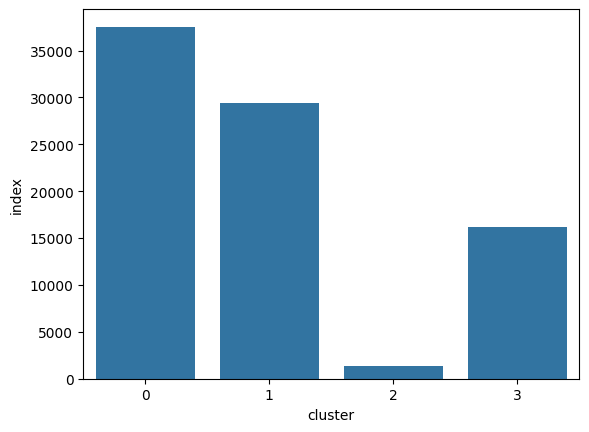

In [62]:
sns.barplot(x='cluster', y='index', data=user_count_by_cluster)

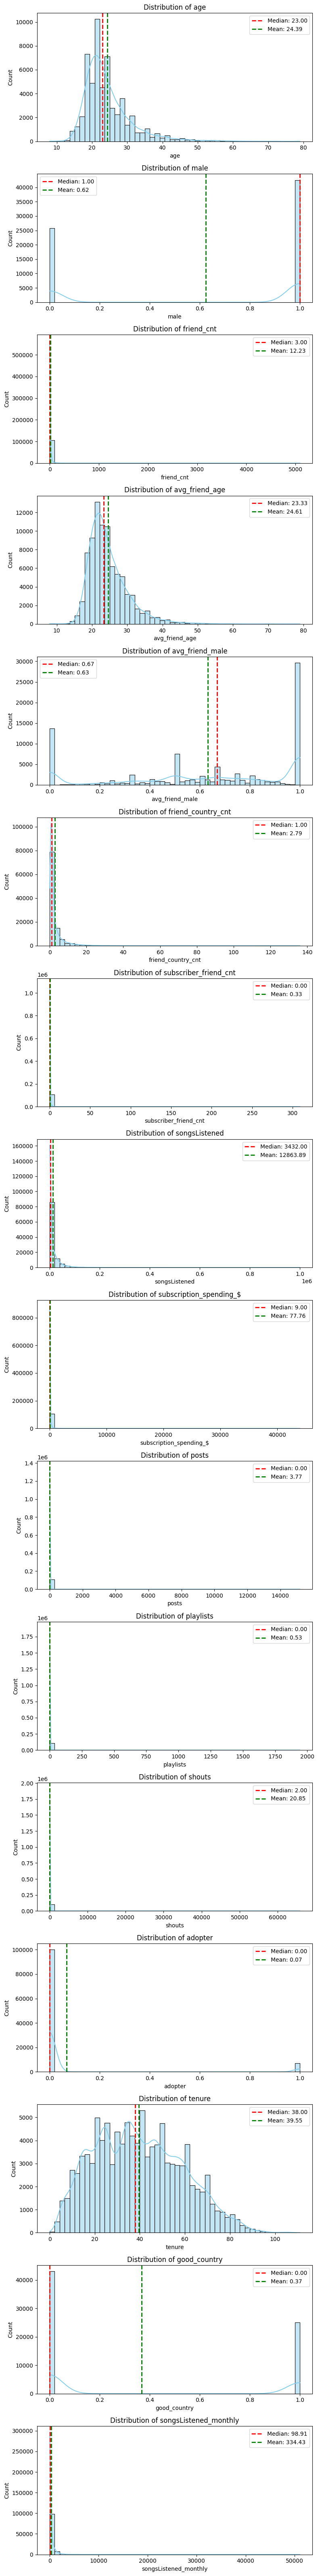

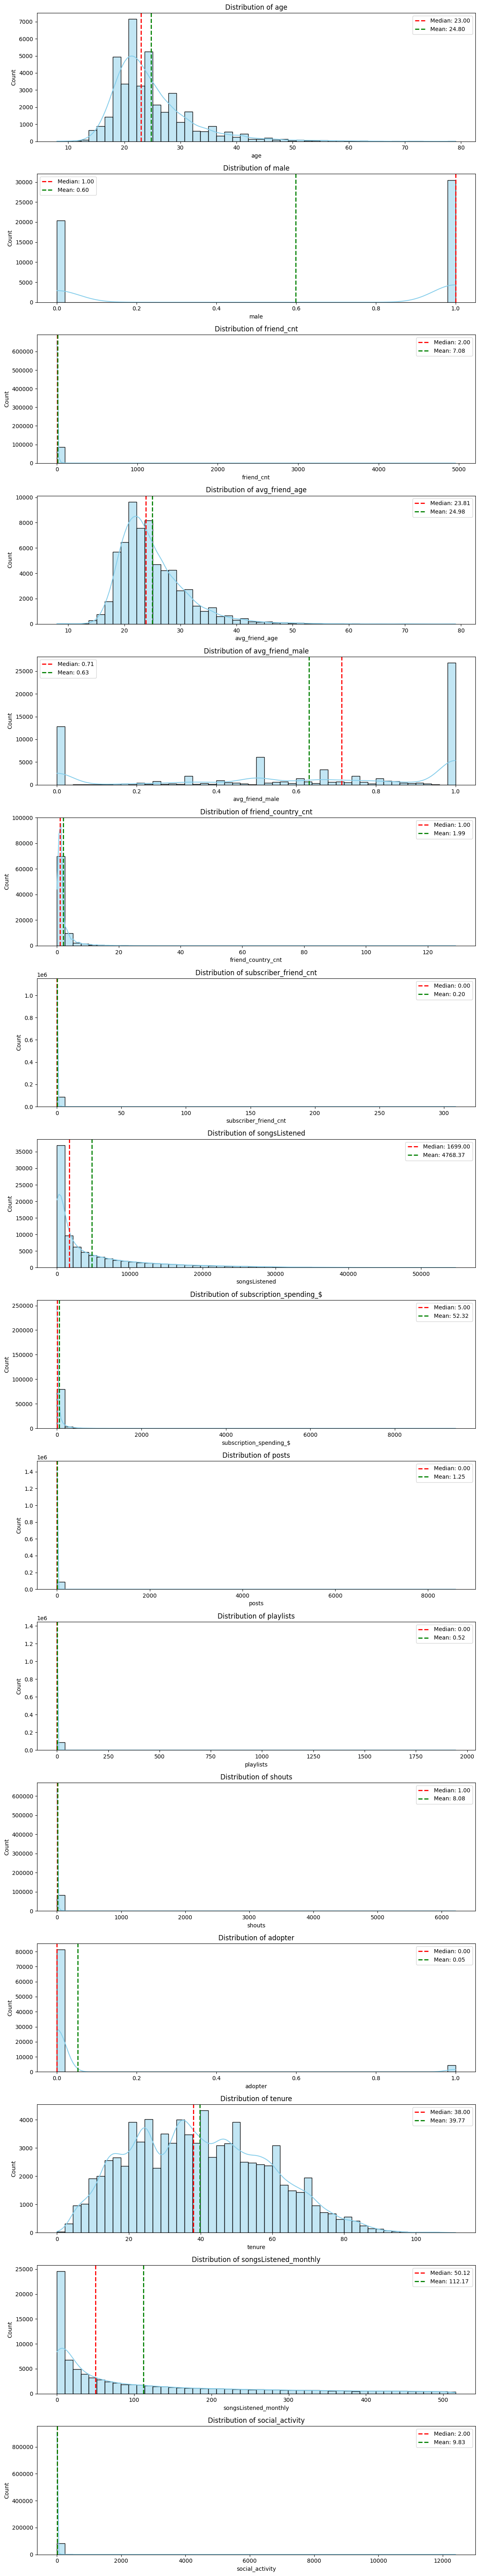

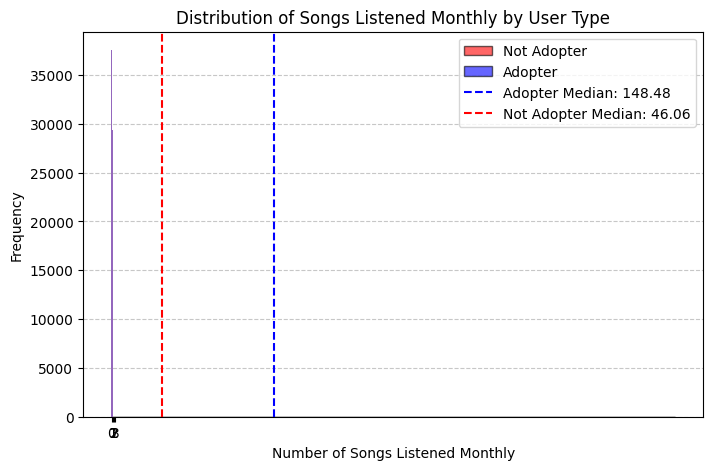

In [58]:
plt.bar(x=user_count_by_cluster['cluster'], height=user_count_by_cluster['index'])
plt.show()

In [64]:
import scorecardpy as sc

In [70]:
data = catalog.load("card_df")

[02/20/25 14:18:34] INFO     Loading data from card_df (CSVDataset)...                          ]8;id=235912;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=716764;file:///opt/miniconda3/envs/musicmap_env/lib/python3.13/site-packages/kedro/io/data_catalog.py#390\390]8;;\

In [72]:
data.head(10)

,variable,bin,points
0,basepoints,NaN,599.0
1,songsListened_monthly,"[-inf,10.0)",69.0
2,songsListened_monthly,"[10.0,20.0)",28.0
3,songsListened_monthly,"[20.0,100.0)",-2.0
4,songsListened_monthly,"[100.0,inf)",-25.0
5,shouts,"[-inf,3.0)",-11.0
6,shouts,"[3.0,5.0)",-2.0
7,shouts,"[5.0,13.0)",12.0
8,shouts,"[13.0,inf)",43.0
9,posts,"[-inf,1.0)",0.0
